In [1]:
import sys, os, time
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

from pyspark.sql import functions as fn
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation

## Data Processing

### Run once to load all of the data into HDFS

In [ ]:
epoch = datetime.utcfromtimestamp(0)
start = int((datetime.now() - timedelta(365 * 20) - epoch).total_seconds())
end = int((datetime.now() - epoch).total_seconds())

!rm -rf data
!mkdir -p data

sp500_series = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0][['Symbol']]
sp500_series['Symbol'] = sp500_series['Symbol'].str.replace('.', '-', regex=False)
sp500_series.to_csv('data/sp500.txt', header=False, index=False)

for t in sp500_series['Symbol']:
    !curl "https://query1.finance.yahoo.com/v7/finance/download/{t}?period1={start}&period2={end}&interval=1d&includeAdjustedClose=true" > data/{t}.csv

!hadoop fs -rmr /data
!hadoop fs -put data /

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  351k    0  351k    0     0  1684k      0 --:--:-- --:--:-- --:--:-- 1689k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  327k    0  327k    0     0  1684k      0 --:--:-- --:--:-- --:--:-- 1685k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  344k    0  344k    0     0  2298k      0 --:--:-- --:--:-- --:--:-- 2309k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178k    0  178k    0     0  1763k      0 --:--:-- --:--:-- --:--:-- 1769k
  % Total    % Received % Xferd  Average Speed   Tim

### Load Data into PySpark

In [2]:
with open('data/sp500.txt', 'r') as file:
    sp500 = file.read().strip().split('\n')

schema = StructType([
    StructField('Date', TimestampType(), False),
    StructField('Open', DoubleType(), True),
    StructField('High', DoubleType(), True),
    StructField('Low', DoubleType(), True),
    StructField('Close', DoubleType(), True),
    StructField('Adj Close', DoubleType(), True),
    StructField('Volume', DoubleType(), True)
])

dfs = [
    spark.read.csv(f'/data/{t}.csv', header=True, schema=schema).withColumn('Tick', fn.lit(t))
    for t in sp500
]

df = reduce(DataFrame.unionByName, dfs)
df = df.drop('Close').withColumnRenamed('Adj Close', 'Close')
df = df.select(
    'Date', 'Tick',
    *(fn.log(c).alias(c) for c in df.columns if c not in ['Date', 'Tick'])
)

### Feature Engineering

In [3]:
SHORT = 10

tick_partition = Window.partitionBy('Tick').orderBy('Date')
short_window = tick_partition.rowsBetween(1 - SHORT, 0)

df_fe = (
    df
    .select(
        fn.col('*'),
        (fn.col('Close') - fn.lag('Close', 1).over(tick_partition)).alias('Return'),
        fn.avg('Close').over(short_window).alias('Rolling_Close'),
        fn.avg('Volume').over(short_window).alias('Rolling_Volume'),
        (fn.col('High') - fn.col('Low')).alias('Spread')
    )
    .select(
        fn.col('*'),
        (fn.col('Close') - fn.col('Rolling_Close')).alias('Momentum'),
        (fn.col('Volume') - fn.col('Rolling_Volume')).alias('Surge'),
        fn.stddev('Return').over(short_window).alias('Volatility'),
        fn.lag('Return', -1).over(tick_partition).alias('Return_lag')
    )
)
df_fe.cache().count()

features = df_fe.select(
    'Date', 'Tick', 'Return', 'Momentum', 'Surge', 'Volatility', 'Spread', 'Return_lag'
).na.drop()

features.cache().count()
df_fe.unpersist()

23/04/27 20:43:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/04/27 20:44:35 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1493.5 KiB
23/04/27 20:44:55 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1501.5 KiB


DataFrame[Date: timestamp, Tick: string, Open: double, High: double, Low: double, Close: double, Volume: double, Return: double, Rolling_Close: double, Rolling_Volume: double, Spread: double, Momentum: double, Surge: double, Volatility: double, Return_lag: double]

## Binary Classification

### Data Preparation

In [10]:
assembler = VectorAssembler(inputCols=['Return', 'Momentum', 'Surge', 'Volatility', 'Spread'], outputCol='features')

In [6]:
bin_data = features.withColumn('Return_lag', (fn.col('Return_lag') > 0).cast('double'))
train_data = bin_data.filter(fn.col('Date') <= datetime.now() - timedelta(100))
test_data = bin_data.filter(fn.col('Date') > datetime.now() - timedelta(100))

train_data.cache().count()
test_data.cache().count()

34706

### Run the models

In [ ]:
classifiers = {
    'lr': LogisticRegression(featuresCol='features', labelCol='Return_lag'),
    'rf': RandomForestClassifier(featuresCol='features', labelCol='Return_lag'),
    'gbt': GBTClassifier(featuresCol='features', labelCol='Return_lag'),
    'svc': LinearSVC(featuresCol='features', labelCol='Return_lag'),
}

preds = []
times = []
auc = []
for name, cls in classifiers.items():
    print(name)
    
    pipeline = Pipeline(stages=[assembler, cls])
    
    # Run the model
    start = time.perf_counter()

    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)
    predictions.cache().count()

    end = time.perf_counter()
    
    # Clean the predictions
    predictions = predictions.select(
        fn.col('Date'), fn.col('Tick'),
        fn.lit(name).alias('Model'),
        fn.col('rawPrediction').alias('Raw'),
        fn.col('prediction').cast('int').alias('Pred'),
        fn.col('Return_lag').cast('int').alias('True')
    )
    
    # Compute the AUCs
    roc = BinaryClassificationEvaluator(labelCol='True', rawPredictionCol='Raw', metricName='areaUnderROC')
    pr = BinaryClassificationEvaluator(labelCol='True', rawPredictionCol='Raw', metricName='areaUnderPR')
    
    auc_roc = roc.evaluate(predictions)
    auc_pr = pr.evaluate(predictions)
    
    # Record all the metrics
    auc.append(spark.createDataFrame([[name, auc_roc, auc_pr]], ['Model', 'AUC-ROC', 'AUC-PR']))
    times.append(spark.createDataFrame([[name, end - start]], ['Model', 'Time']))
    preds.append(predictions.drop('Raw'))

lr
rf
gbt
svc


### Collect the evaluation metrics

In [ ]:
auc = reduce(DataFrame.unionByName, auc)
times = reduce(DataFrame.unionByName, times)
preds = reduce(DataFrame.unionByName, preds)

confusion = preds.drop('Date', 'Tick').groupBy('Model').agg(
    fn.sum(fn.col('Pred') * fn.col('True')).alias('TP'),
    fn.sum((1 - fn.col('Pred')) * (1 - fn.col('True'))).alias('TN'),
    fn.sum(fn.col('Pred') * (1 - fn.col('True'))).alias('FP'),
    fn.sum((1 - fn.col('Pred')) * fn.col('True')).alias('FN'),
    fn.count('Pred').alias('Total')
)

accuracy = confusion.select(
    fn.col('Model'),
    (fn.col('TP') / (fn.col('TP') + fn.col('FN'))).alias('a1'),
    (fn.col('TN') / (fn.col('TN') + fn.col('FP'))).alias('a2')
).select(
    fn.col('Model'),
    (0.5 * (fn.col('a1') + fn.col('a2'))).alias('Accuracy')
)

info = accuracy.join(times, on='Model').join(auc, on='Model')
info.show()

+-----+------------------+-----------------+------------------+------------------+
|Model|          Accuracy|             Time|           AUC-ROC|            AUC-PR|
+-----+------------------+-----------------+------------------+------------------+
|   rf|0.5046606680114534|     49.084258976|0.5144386005418169|0.5080985511893077|
|   lr|0.5037664720387234|50.82566294899999|0.5179076520587367| 0.519829955640539|
|  gbt|0.5071392016941755|382.6928634169999|0.5196404841730198|0.5119657832753376|
|  svc|               0.5|    679.732752051|0.5031318120921708|0.4993444203095544|
+-----+------------------+-----------------+------------------+------------------+



In [16]:
info.write.format('parquet').save("/wn6")

### Run Logistic Regression Iteration by Iteration

In [25]:
NUM_EPOCHS = 10

lr = LogisticRegression(featuresCol='features', labelCol='Return_lag', maxIter=1)

train_ass = assembler.transform(train_data)
test_ass = assembler.transform(test_data)

train_ass.cache().count()
test_ass.cache().count()

iter_scores = []

for i in range(-1, NUM_EPOCHS):
    print(i)
    lr.setMaxIter(i + 1)
    
    start = time.perf_counter()
    model = lr.fit(train_ass)
    
    predictions = model.transform(test_ass)
    
    train_acc = model.summary.accuracy

    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Return_lag')
    test_acc = evaluator.evaluate(predictions)
    end = time.perf_counter()
    
    iter_scores.append(
        spark.createDataFrame(
            [[i + 1, train_acc, test_acc, end - start]],
            ['Iters', 'Train_Acc', 'Test_Acc', 'Time']
        )
    )

iter_scores = reduce(DataFrame.unionByName, iter_scores)

-1
0
1
2
3
4
5
6
7
8
9


In [28]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *
from functools import reduce

NUM_EPOCHS = 10

assembler = VectorAssembler(inputCols=['Return', 'Momentum', 'Surge', 'Volatility', 'Spread'], outputCol='features')
rf = RandomForestClassifier(featuresCol='features', labelCol='Return_lag', numTrees = 10)

train_ass = assembler.transform(train_data)
test_ass = assembler.transform(test_data)

train_ass.cache().count()
test_ass.cache().count()

tree_scores = []

for i in range(0, NUM_EPOCHS):
    print(i)
    rf.setNumTrees(i + 1)
    
    start = time.perf_counter()
    model = rf.fit(train_ass)
    
    predictions = model.transform(test_ass)
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Return_lag')
    train_acc = evaluator.evaluate(model.transform(train_ass))
    test_acc = evaluator.evaluate(predictions)
    end = time.perf_counter()
    
    tree_scores.append(
        spark.createDataFrame(
            [[i + 1, train_acc, test_acc, end - start]],
            ['Trees', 'Train_Acc', 'Test_Acc', 'Time']
        )
    )

tree_scores = reduce(DataFrame.unionByName, tree_scores)


0
1
2
3
4
5
6
7
8
9


### Plot the Results

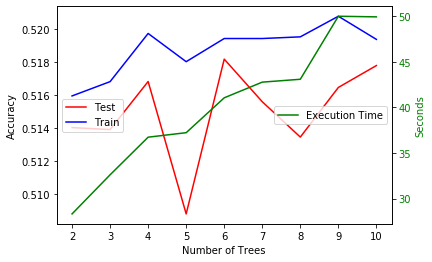

In [29]:
iter_, train, test, times = zip(*tree_scores.collect()[1:])

fig, ax1 = plt.subplots()

ax1.plot(iter_, test, label='Test', color='red')
ax1.plot(iter_, train, label='Train', color='blue')
ax1.set_xlabel('Number of Trees')
ax1.set_ylabel('Accuracy', color='black')
ax1.legend(loc='center left')

ax2 = ax1.twinx()
ax2.plot(iter_, times, label='Execution Time', color='green')
ax2.set_ylabel('Seconds', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='center right')

plt.show()

## Portfolio Optimization

This is an interesting tangent where we use linear regression to predict returns, and then use these predictions to maximize an objective function. We use the same features as in binary classification, but now predict real valued log-returns. Using these predictions, we maximize $$f(w) = E(\text{Return(w)}) - \alpha Var(\text{Return(w)})$$ where $w_i$ is the capital allocation to each stock. We do this using a Lagrange multiplier with constraint $\sum w_i = 1$.

### Data Preparation

In [4]:
returns = (
    features
    .select('Date', 'Tick', 'Return')
    .groupBy('Date')
    .pivot('Tick')
    .agg(fn.collect_list('Return').getItem(0))
)
    
returns = returns.select(
    fn.col('Date'),
    *(fn.exp(c).alias(c) for c in returns.drop('Date').columns),
)

returns_assembler = VectorAssembler(
    inputCols=returns.drop('Date').columns,
    outputCol='features',
    handleInvalid='keep'
)

returns_vector = returns_assembler.transform(returns.na.drop()).select("features")

23/04/27 20:45:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1506.3 KiB
23/04/27 20:45:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1506.0 KiB


### Train/test split

In [5]:
cutoff = datetime.now() - timedelta(60)

train_data = features.filter(fn.col('Date') <= cutoff)
test_data = features.filter(fn.col('Date') > cutoff)

In [6]:
train_returns = returns.filter(fn.col('Date') <= cutoff)
test_returns = returns.filter(fn.col('Date') > cutoff)

In [7]:
train_returns_vector = returns_vector.filter(fn.col('Date') <= cutoff)

### Compute the covariance matrix

In [8]:
corr = Correlation.corr(train_returns_vector, 'features')
corr = corr.head()[0].toArray()

devs = train_returns.select(*(fn.stddev(c).alias(c) for c in train_returns.columns if c != 'Date'))
devs = np.array(devs.head())

cov = corr * np.outer(devs, devs)

cov = np.block([
    [cov, np.zeros((cov.shape[0], 1))],
    [np.zeros((1, cov.shape[0])), np.zeros((1, 1))]
])

23/04/27 20:45:10 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/04/27 20:45:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1604.3 KiB
23/04/27 20:45:32 ERROR org.apache.spark.sql.catalyst.expressions.codegen.CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "processNext()V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:3

### Linear Regression for Returns Predictions

In [11]:
lr = LinearRegression(featuresCol='features', labelCol='Return_lag')

pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(train_data)

predictions = model.transform(test_data).select('Date', 'Tick', 'prediction')
truths = test_data.select('Date', 'Tick', 'Return_lag')

sigma2 = (
    predictions
    .join(truths, on=['Date', 'Tick'])
    .select(
        fn.sum((fn.col('prediction') - fn.col('Return_lag')) ** 2) / (predictions.count() - len(features.columns))
    )
).collect()[0][0]

preds = (
    predictions
    .groupBy('Date')
    .pivot('Tick')
    .agg(fn.collect_list('prediction').getItem(0))
    .sort('Date')
    .na.drop()
)

e_preds = preds.select(
    fn.col('Date'),
    *(fn.exp(fn.col(c) + sigma2/2).alias(c) for c in preds.columns if c != 'Date'),
    fn.lit(1.).alias('USD')
)

preds_array = np.array(e_preds.withColumn('Constraint', fn.lit(1.)).drop('Date').collect())

23/04/27 20:47:26 WARN org.apache.spark.ml.util.Instrumentation: [913fd72b] regParam is zero, which might cause numerical instability and overfitting.
23/04/27 20:47:26 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1526.3 KiB
23/04/27 20:47:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1527.4 KiB
23/04/27 20:47:33 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/27 20:47:33 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/04/27 20:47:33 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/27 20:47:33 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
23/04/27 20:47:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task

### Solve the Optimization Problem

In [28]:
ALPHA = 1e17
left = np.block([
    [2*ALPHA*cov, -np.ones((cov.shape[0], 1))],
    [np.ones((1, cov.shape[0])), np.zeros((1, 1))]
])

right = preds_array.T

ws = np.linalg.solve(left, right)[:-1].T
dates = np.array(preds.select('Date').collect())
ws = np.concatenate([dates, ws], axis=1).tolist()

23/04/27 21:03:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1630.9 KiB
23/04/27 21:03:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2004.0 KiB
23/04/27 21:03:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2005.2 KiB
23/04/27 21:03:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1730.3 KiB


### Portfolio Construction

In [29]:
portfolio = spark.createDataFrame(ws, e_preds.columns)
portfolio = portfolio.select(
    fn.col('Date'),
    *(fn.col(c).alias(c + '_w') for c in portfolio.columns if c != 'Date')
)

portfolio = test_returns.join(portfolio, on='Date').withColumn('USD', fn.lit(1.0))

ind_performance = portfolio.select(
    fn.col('Date'),
    *((fn.col(c) * fn.col(c + '_w')).alias(c) for c in returns.columns + ['USD'] if c != 'Date')
)

performance = ind_performance.select(
    fn.col('Date'),
    sum(ind_performance.drop('Date')).alias('Return')
).sort('Date')

### Plot the Results

23/04/27 21:03:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1607.5 KiB
23/04/27 21:03:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1910.5 KiB
23/04/27 21:03:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1912.3 KiB
23/04/27 21:03:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1911.1 KiB


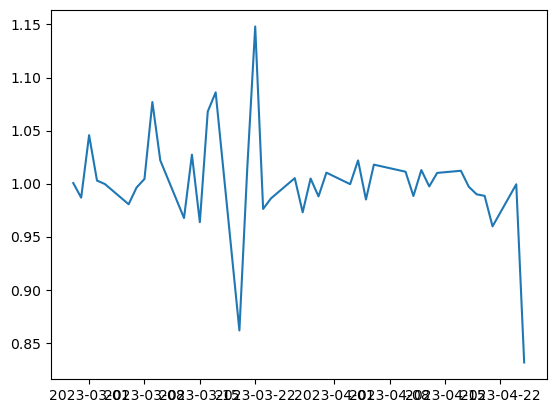

In [30]:
dates, values = zip(*performance.collect())

plt.figure()
plt.plot(dates, values)
plt.show()